In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

In [4]:
od.download("https://www.kaggle.com/tawsifurrahman/covid19-radiography-database")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saadur1998
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


In [5]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [6]:
data_dir = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset'
!rm -rf 'find -type d -name .ipynb_checkpoints'
classes = os.listdir(data_dir)
print(classes)

['COVID', 'README.md.txt', 'Viral Pneumonia', 'COVID.metadata.xlsx', 'Normal.metadata.xlsx', 'Lung_Opacity', 'Normal', 'Lung_Opacity.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx']


In [7]:
from torchvision.datasets import ImageFolder

transformations = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [8]:
dataset

Dataset ImageFolder
    Number of datapoints: 42330
    Root location: /content/covid19-radiography-database/COVID-19_Radiography_Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [9]:
def show_image(img, label):
  print('Label: ', dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

Label:  COVID


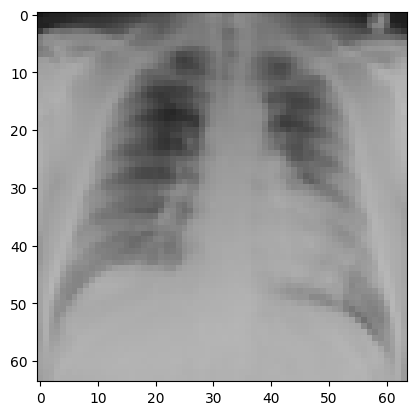

In [10]:
img, label = dataset[28]
show_image(img, label)

Label:  Normal


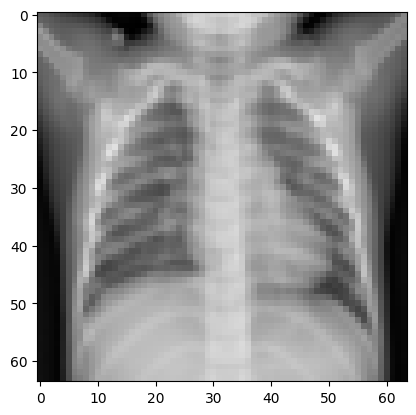

In [11]:
img, label = dataset[20150]
show_image(img, label)

Label:  Viral Pneumonia


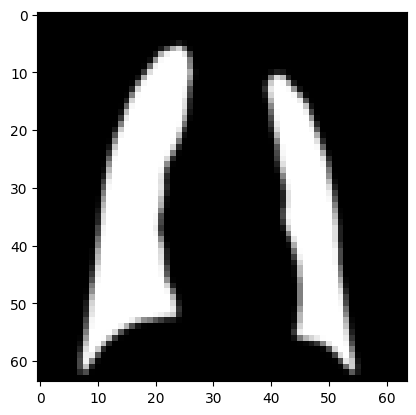

In [12]:
img, label = dataset[41344]
show_image(img, label)

In [13]:
random_seed = 51
torch.manual_seed(random_seed)

ds_train, ds_test = random_split(dataset, [33864, 8466])
len(ds_train), len(ds_test)

(33864, 8466)

In [14]:
batch_size = 200
dl_train = DataLoader(ds_train, batch_size, shuffle=True, num_workers=3, pin_memory=True)
dl_valid = DataLoader(ds_test, batch_size, num_workers=3, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [15]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(14,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=20).permute(1,2,0))
    break

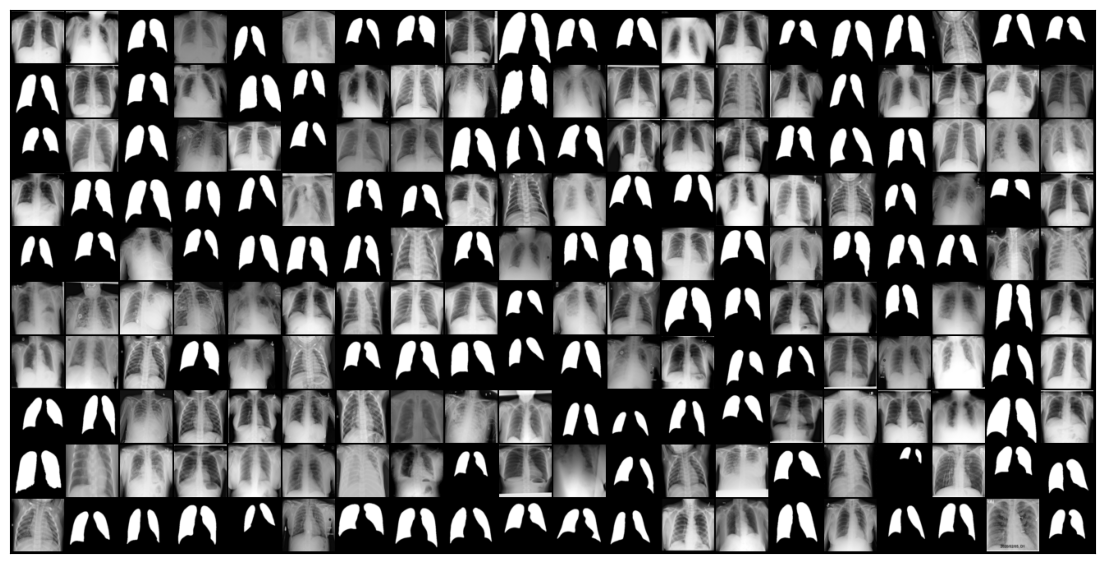

In [16]:
show_batch(dl_train)

In [23]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
dl_train = DeviceDataLoader(dl_train, device)
dl_valid = DeviceDataLoader(dl_valid, device)